In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
import scipy.stats as stats
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel

In [21]:
df_daily = pd.read_excel('dataset_group4.xlsx', sheet_name='Kurs Transaksi USD', header=0)
df_monthly_inflasi = pd.read_excel('dataset_group4.xlsx', sheet_name='Inflasi', header=0)
df_monthly_BIRate = pd.read_excel('dataset_group4.xlsx', sheet_name='BI Rate', header=0)
df_monthly_cadanganDevisa = pd.read_excel('dataset_group4.xlsx', sheet_name='Cadangan Devisa', header=0)

df_daily['Tanggal'] = pd.to_datetime(df_daily['Tanggal'])

bulan_mapping = {
    'Januari': 'January', 'Februari': 'February', 'Maret': 'March',
    'April': 'April', 'Mei': 'May', 'Juni': 'June',
    'Juli': 'July', 'Agustus': 'August', 'September': 'September',
    'Oktober': 'October', 'November': 'November', 'Desember': 'December'
}

df_monthly_inflasi['Period'] = df_monthly_inflasi['Period'].replace(bulan_mapping, regex=True)
df_monthly_inflasi['year_month'] = pd.to_datetime(df_monthly_inflasi['Period'], format='%B %Y').dt.to_period('M')

df_monthly_BIRate['Period'] = df_monthly_BIRate['Period'].replace(bulan_mapping, regex=True)
df_monthly_BIRate['year_month'] = pd.to_datetime(df_monthly_BIRate['Period'], format='%B %Y').dt.to_period('M')

df_monthly_cadanganDevisa['Period'] = df_monthly_cadanganDevisa['Period'].replace(bulan_mapping, regex=True)
df_monthly_cadanganDevisa['year_month'] = pd.to_datetime(df_monthly_cadanganDevisa['Period'], format='%B %Y').dt.to_period('M')

df_daily['year_month'] = df_daily['Tanggal'].dt.to_period('M')

In [22]:
df_monthly_neraca = pd.read_excel('dataset_group4.xlsx', sheet_name='Neraca', header=0)

df_monthly_neraca['Period'] = df_monthly_neraca['Period'].replace(bulan_mapping, regex=True)
df_monthly_neraca['year_month'] = pd.to_datetime(df_monthly_neraca['Period'], format='%B %Y').dt.to_period('M')

kolom_angka = ['Ekspor Migas', 'Ekspor Non Migas', 'Impor Migas', 'Impor Non Migas', 'Neraca Migas', 'Neraca Non Migas']

for kolom in kolom_angka:
    df_monthly_neraca[kolom] = (
        df_monthly_neraca[kolom]
        .astype(str)
        .str.replace(r'[^\d\-]', '', regex=True)
        .replace('', np.nan)
        .astype(float)
    )

df = (
    df_daily
    .merge(df_monthly_inflasi[['year_month', 'Umum', 'Inti', 'Harga Yang Diatur Pemerintah', 'Barang Bergejolak']], on='year_month', how='left')
    .merge(df_monthly_BIRate[['year_month', 'BI Rate']], on='year_month', how='left')
    .merge(df_monthly_neraca[['year_month', 'Ekspor Migas', 'Ekspor Non Migas', 'Impor Migas', 'Impor Non Migas', 'Neraca Migas', 'Neraca Non Migas']], on='year_month', how='left')
    .merge(df_monthly_cadanganDevisa[['year_month', 'Uang Kertas dan Uang Logam yang Diedarkan', 'Saldo Giro Bank pada BI', 'Posisi Aktiva Luar Negeri Bersih', 'Tagihan Bersih kepada Pemerintah Pusat', 'Kredit Likuiditas', 'Operasi Pasar Terbuka', 'Cadangan Devisa dalam juta USD']], on='year_month', how='left')
    .drop(columns='year_month')
)

df = df.sort_values(by="NO", ascending=False)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3186 entries, 3185 to 0
Data columns (total 23 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   NO                                         3186 non-null   int64         
 1   Nilai                                      3186 non-null   int64         
 2   Kurs Jual                                  3186 non-null   float64       
 3   Kurs Beli                                  3186 non-null   float64       
 4   Tanggal                                    3186 non-null   datetime64[ns]
 5   Umum                                       3186 non-null   float64       
 6   Inti                                       3186 non-null   float64       
 7   Harga Yang Diatur Pemerintah               3186 non-null   float64       
 8   Barang Bergejolak                          3186 non-null   float64       
 9   BI Rate                 

In [23]:
print(df.head(5))

        NO  Nilai  Kurs Jual  Kurs Beli    Tanggal  Umum  Inti  \
3185  3186      1     9171.0     9079.0 2012-01-02  0.76  0.44   
3184  3185      1     9206.0     9114.0 2012-01-03  0.76  0.44   
3183  3184      1     9226.0     9134.0 2012-01-04  0.76  0.44   
3182  3183      1     9209.0     9117.0 2012-01-05  0.76  0.44   
3181  3182      1     9206.0     9114.0 2012-01-06  0.76  0.44   

      Harga Yang Diatur Pemerintah  Barang Bergejolak  BI Rate  ...  \
3185                          0.43               2.02      6.0  ...   
3184                          0.43               2.02      6.0  ...   
3183                          0.43               2.02      6.0  ...   
3182                          0.43               2.02      6.0  ...   
3181                          0.43               2.02      6.0  ...   

      Impor Non Migas  Neraca Migas  Neraca Non Migas  \
3185     1.153503e+10   123041495.0       890399027.0   
3184     1.153503e+10   123041495.0       890399027.0   
3183 

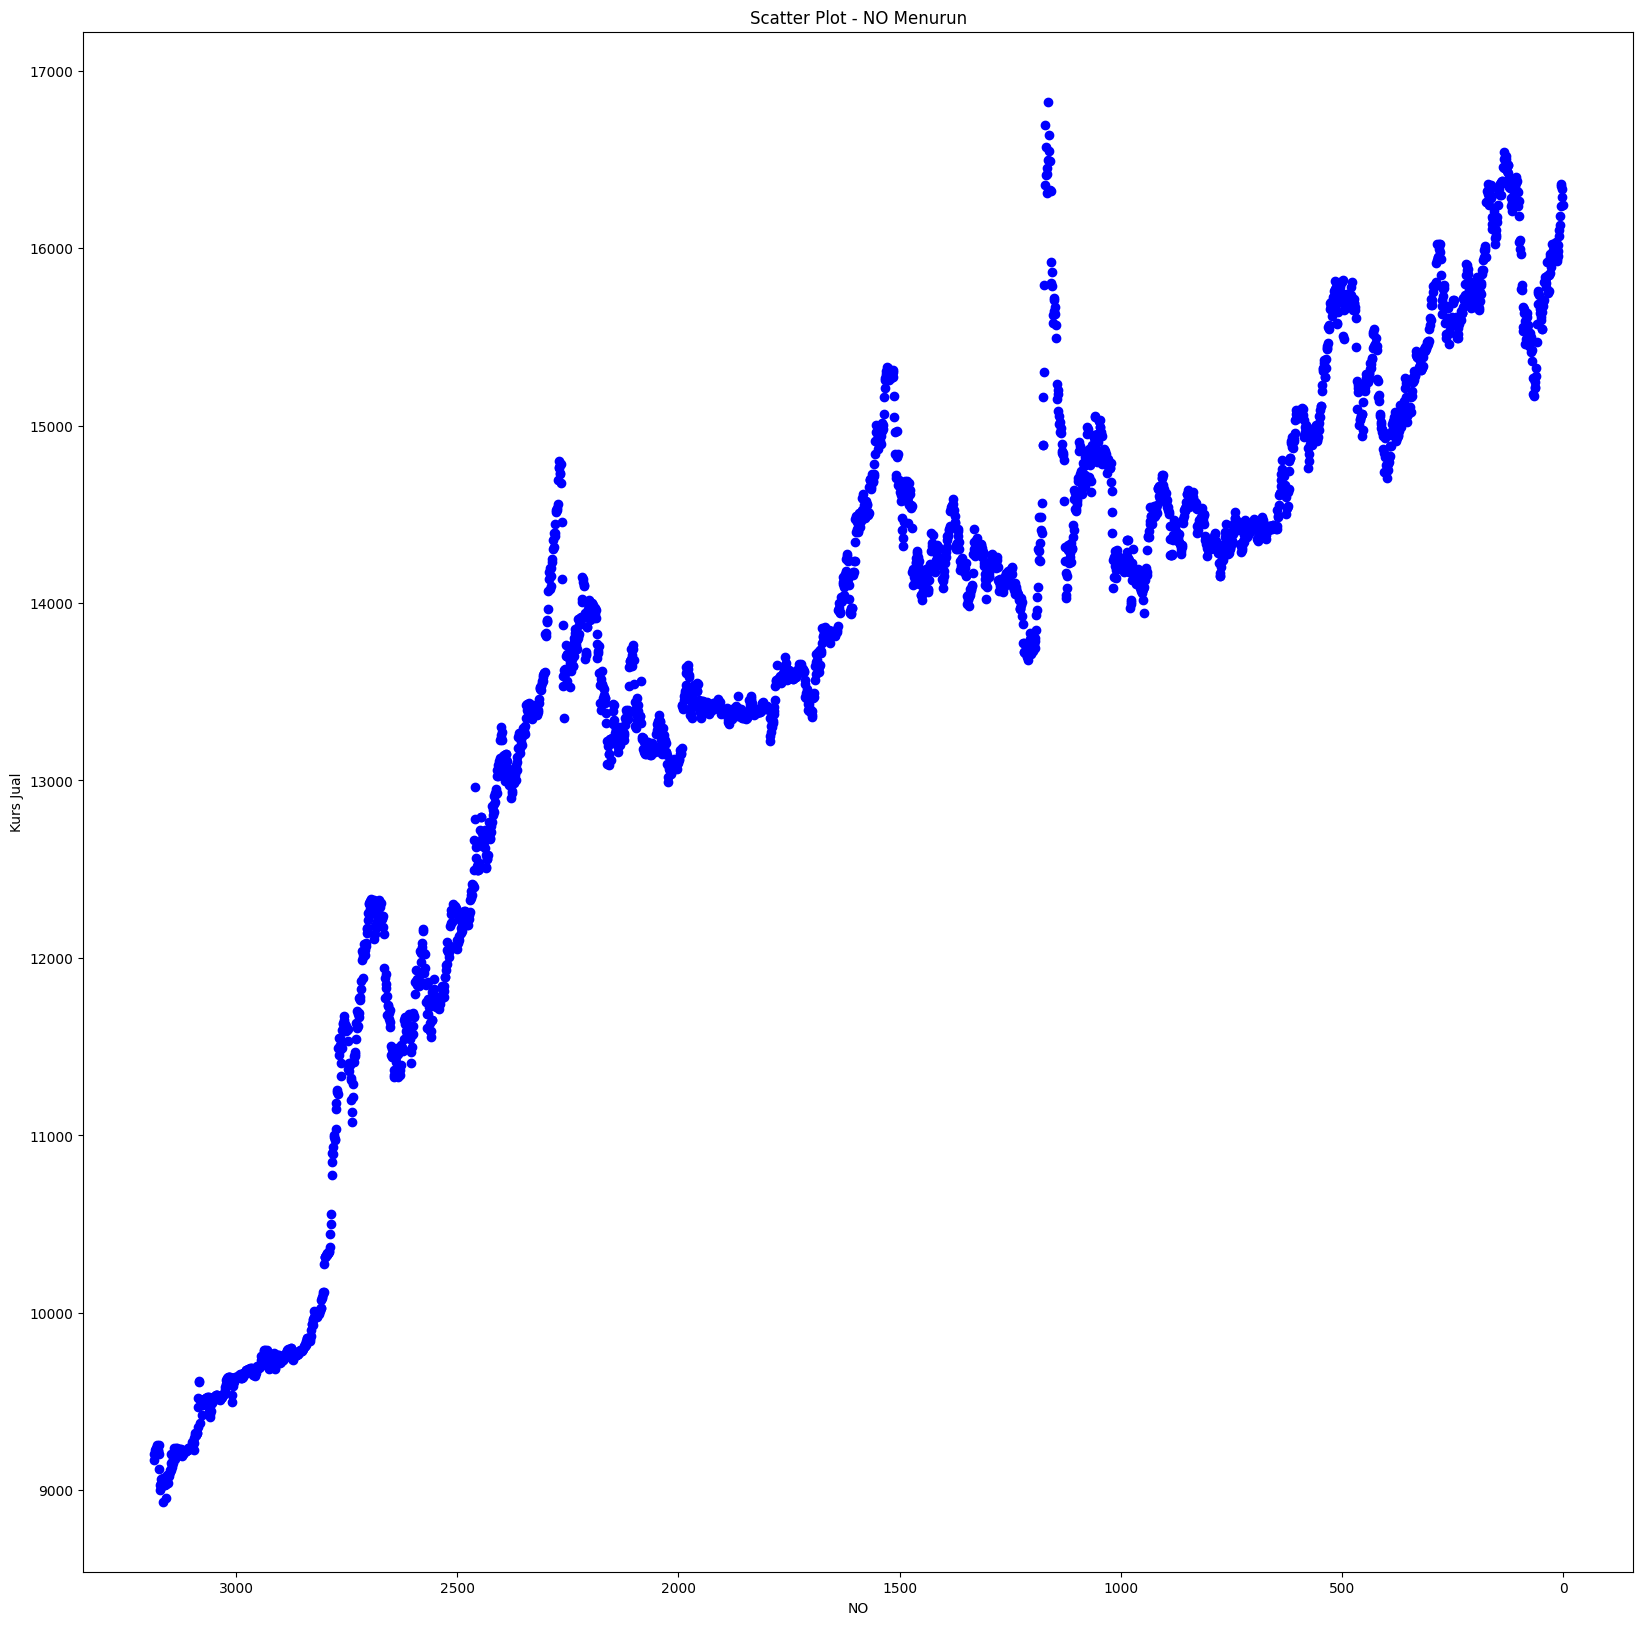

In [24]:
x = df["NO"]
y = df["Kurs Jual"]

plt.figure(figsize=(20, 20)) 
plt.scatter(x, y, color='blue', marker='o')
plt.xlabel('NO')
plt.ylabel('Kurs Jual')
plt.title('Scatter Plot - NO Menurun')
plt.gca().invert_xaxis()
plt.show()

In [25]:
print(df.columns)
df.drop(columns=['NO', 'Tanggal'], inplace=True, errors='ignore')
print(df.columns)
df.isnull().sum()

Index(['NO', 'Nilai', 'Kurs Jual', 'Kurs Beli', 'Tanggal', 'Umum', 'Inti',
       'Harga Yang Diatur Pemerintah', 'Barang Bergejolak', 'BI Rate',
       'Ekspor Migas', 'Ekspor Non Migas', 'Impor Migas', 'Impor Non Migas',
       'Neraca Migas', 'Neraca Non Migas',
       'Uang Kertas dan Uang Logam yang Diedarkan', 'Saldo Giro Bank pada BI',
       'Posisi Aktiva Luar Negeri Bersih',
       'Tagihan Bersih kepada Pemerintah Pusat', 'Kredit Likuiditas',
       'Operasi Pasar Terbuka', 'Cadangan Devisa dalam juta USD'],
      dtype='object')
Index(['Nilai', 'Kurs Jual', 'Kurs Beli', 'Umum', 'Inti',
       'Harga Yang Diatur Pemerintah', 'Barang Bergejolak', 'BI Rate',
       'Ekspor Migas', 'Ekspor Non Migas', 'Impor Migas', 'Impor Non Migas',
       'Neraca Migas', 'Neraca Non Migas',
       'Uang Kertas dan Uang Logam yang Diedarkan', 'Saldo Giro Bank pada BI',
       'Posisi Aktiva Luar Negeri Bersih',
       'Tagihan Bersih kepada Pemerintah Pusat', 'Kredit Likuiditas',
       'Oper

Nilai                                        0
Kurs Jual                                    0
Kurs Beli                                    0
Umum                                         0
Inti                                         0
Harga Yang Diatur Pemerintah                 0
Barang Bergejolak                            0
BI Rate                                      0
Ekspor Migas                                 0
Ekspor Non Migas                             0
Impor Migas                                  0
Impor Non Migas                              0
Neraca Migas                                 0
Neraca Non Migas                             0
Uang Kertas dan Uang Logam yang Diedarkan    0
Saldo Giro Bank pada BI                      0
Posisi Aktiva Luar Negeri Bersih             0
Tagihan Bersih kepada Pemerintah Pusat       0
Kredit Likuiditas                            0
Operasi Pasar Terbuka                        0
Cadangan Devisa dalam juta USD               0
dtype: int64

In [26]:
df['Selisih_Kurs'] = df['Kurs Jual'] - df['Kurs Beli']  
df['Rasio_Kurs'] = df['Kurs Jual'] / df['Kurs Beli']  
df['Saldo_Neraca'] = df['Neraca Migas'] + df['Neraca Non Migas']
df.isnull().sum()

Nilai                                        0
Kurs Jual                                    0
Kurs Beli                                    0
Umum                                         0
Inti                                         0
Harga Yang Diatur Pemerintah                 0
Barang Bergejolak                            0
BI Rate                                      0
Ekspor Migas                                 0
Ekspor Non Migas                             0
Impor Migas                                  0
Impor Non Migas                              0
Neraca Migas                                 0
Neraca Non Migas                             0
Uang Kertas dan Uang Logam yang Diedarkan    0
Saldo Giro Bank pada BI                      0
Posisi Aktiva Luar Negeri Bersih             0
Tagihan Bersih kepada Pemerintah Pusat       0
Kredit Likuiditas                            0
Operasi Pasar Terbuka                        0
Cadangan Devisa dalam juta USD               0
Selisih_Kurs 

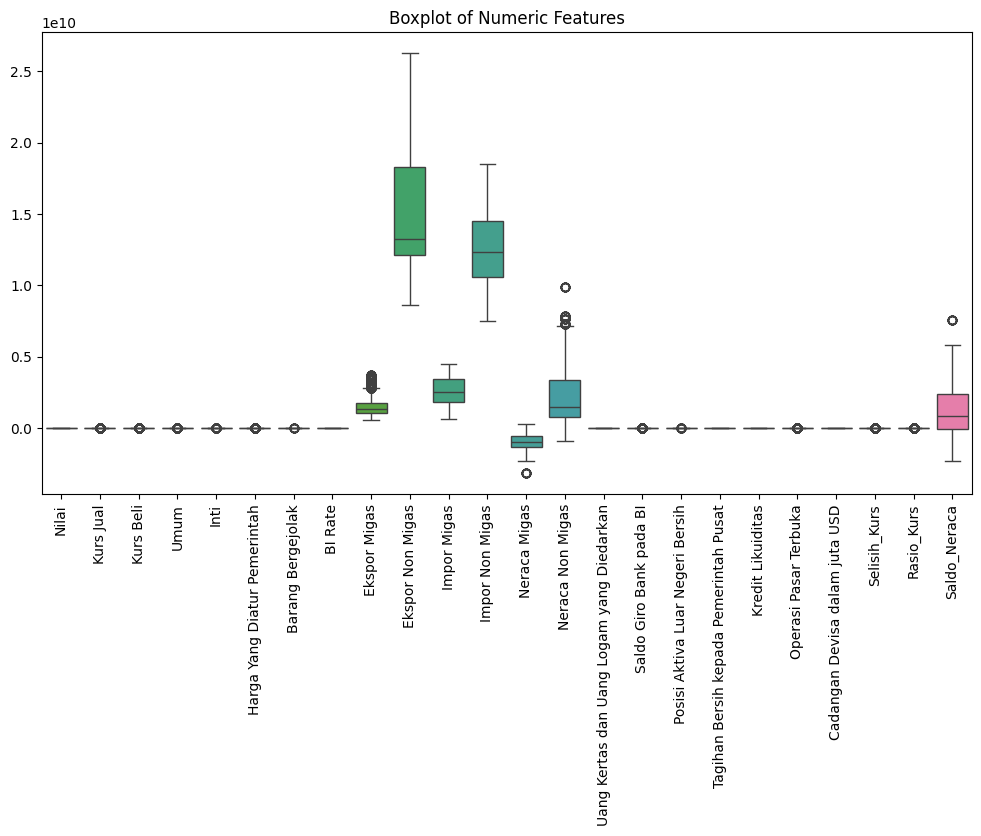

In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.select_dtypes(include='number'))
plt.xticks(rotation=90)
plt.title("Boxplot of Numeric Features")
plt.show()

In [28]:
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
print(numerical_cols)

['Nilai', 'Kurs Jual', 'Kurs Beli', 'Umum', 'Inti', 'Harga Yang Diatur Pemerintah', 'Barang Bergejolak', 'BI Rate', 'Ekspor Migas', 'Ekspor Non Migas', 'Impor Migas', 'Impor Non Migas', 'Neraca Migas', 'Neraca Non Migas', 'Uang Kertas dan Uang Logam yang Diedarkan', 'Saldo Giro Bank pada BI', 'Posisi Aktiva Luar Negeri Bersih', 'Tagihan Bersih kepada Pemerintah Pusat', 'Kredit Likuiditas', 'Operasi Pasar Terbuka', 'Cadangan Devisa dalam juta USD', 'Selisih_Kurs', 'Rasio_Kurs', 'Saldo_Neraca']


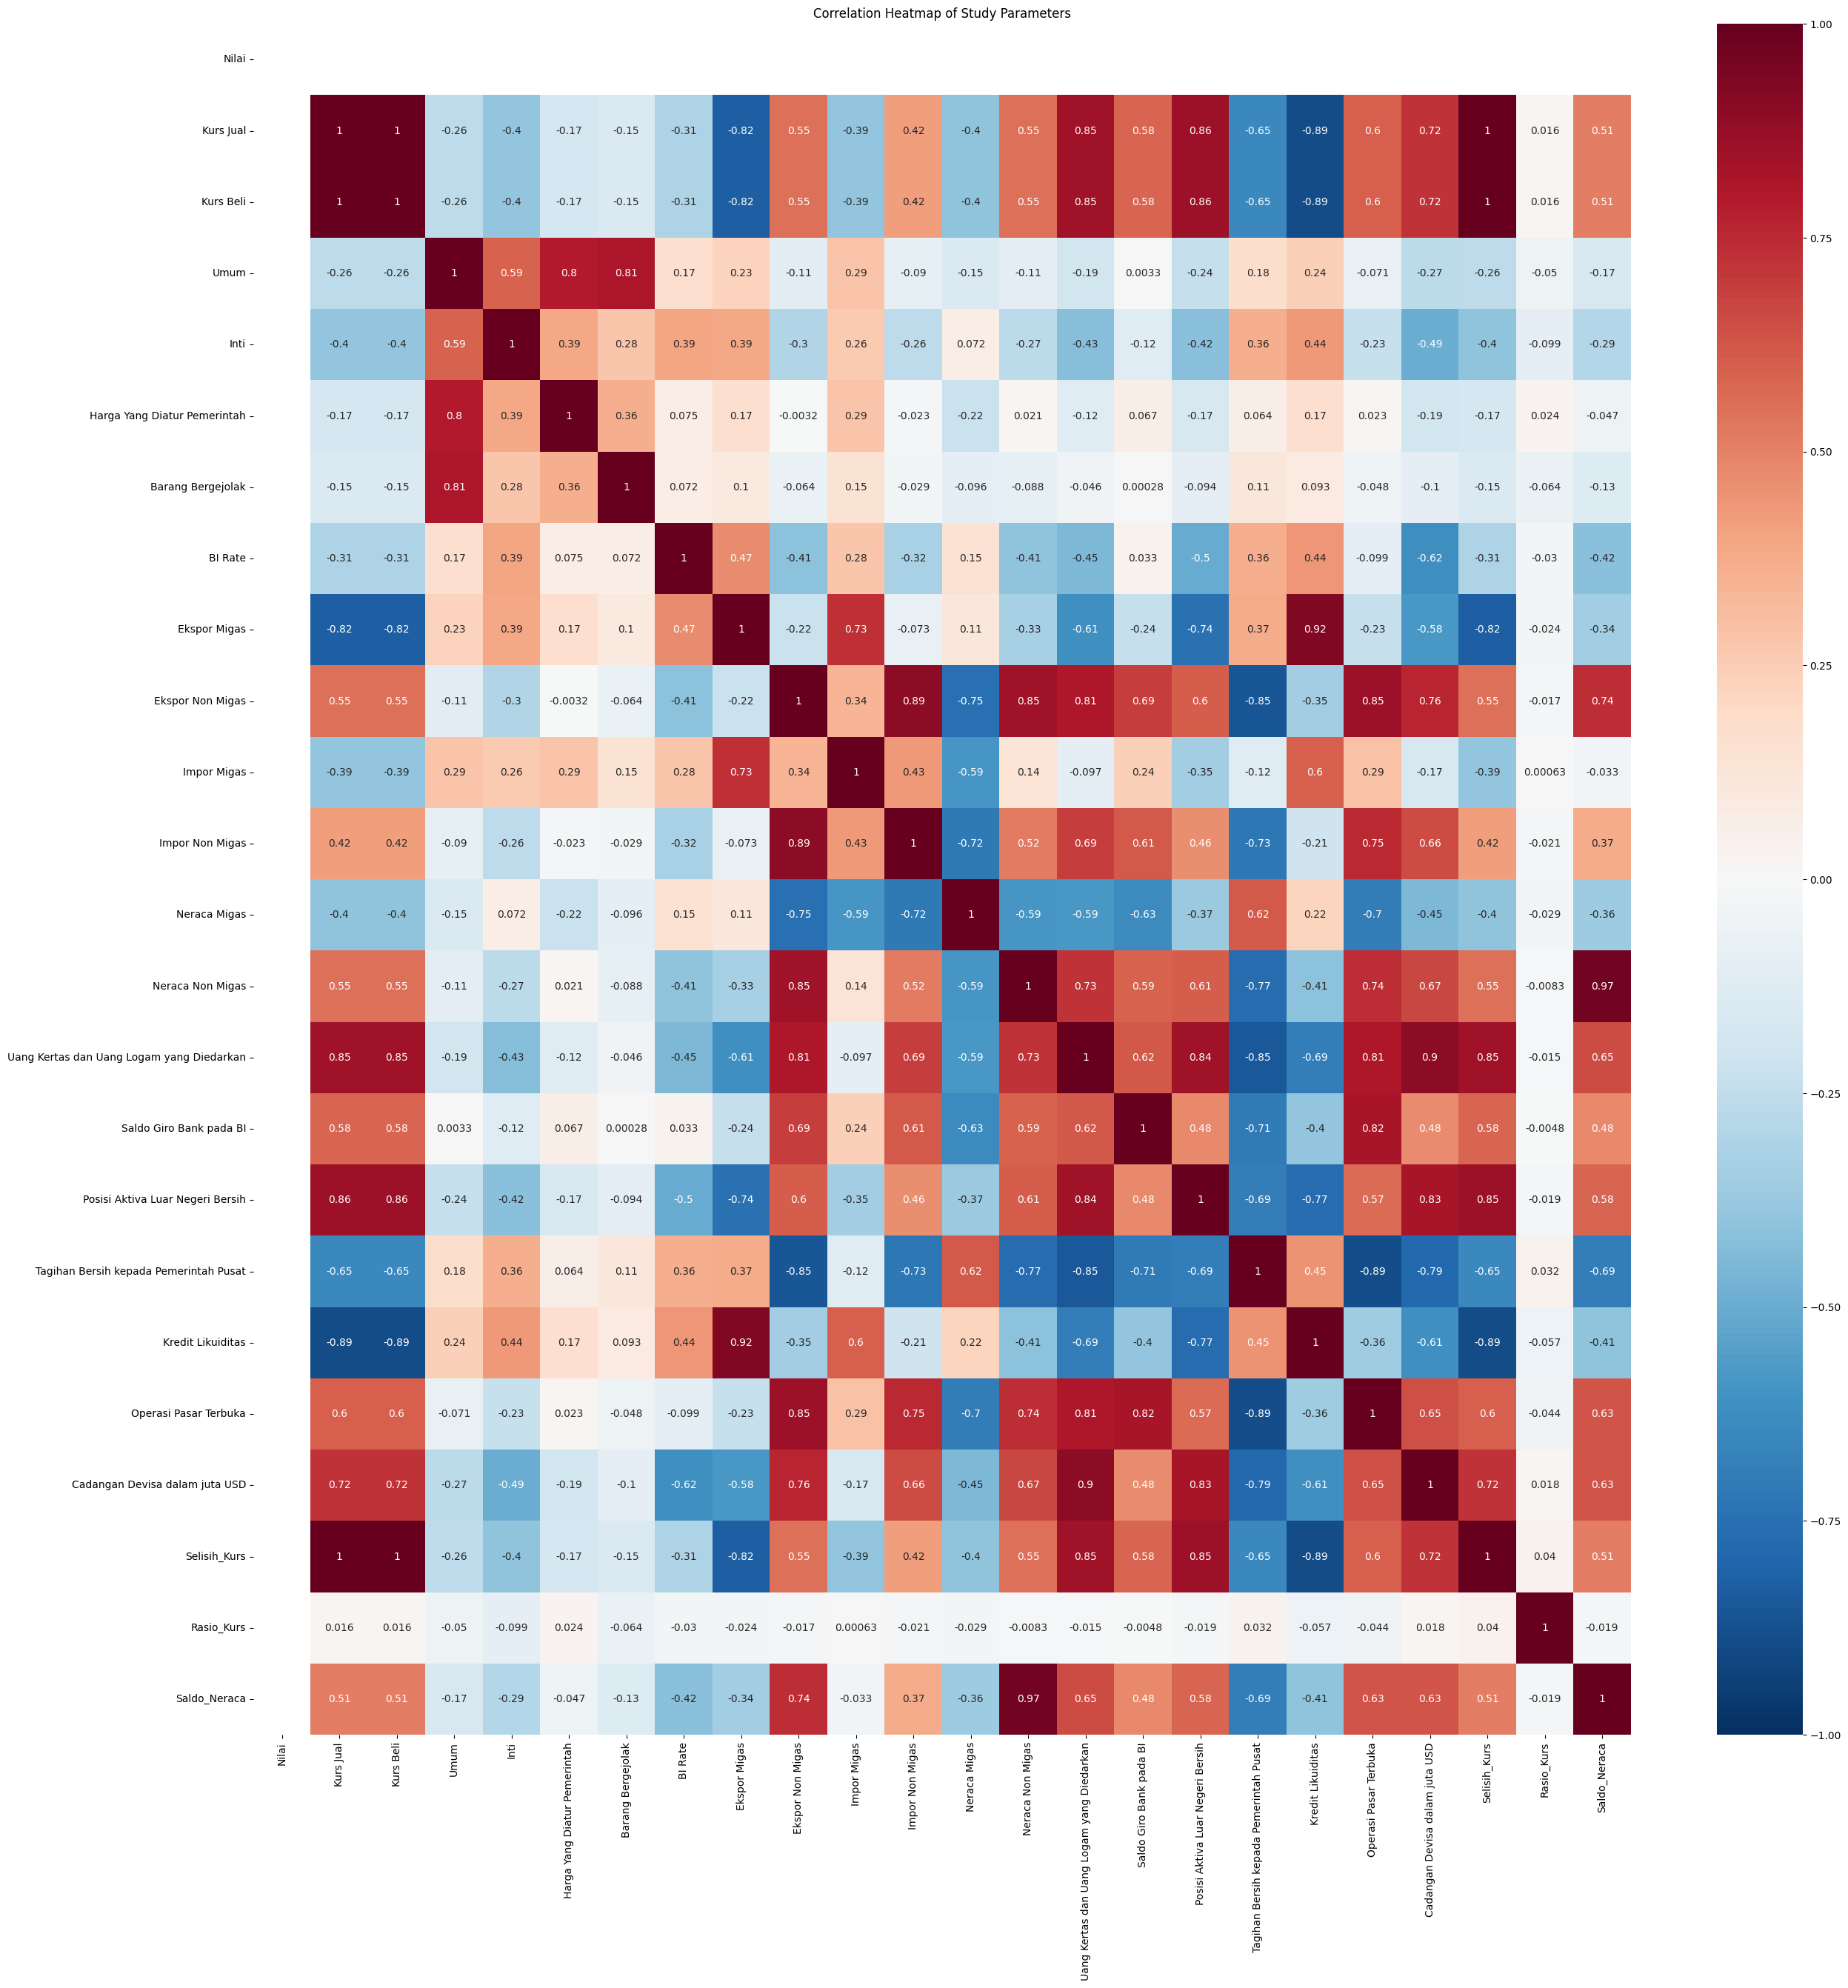

In [29]:
corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Study Parameters')
plt.show()

target_column = 'Kurs Jual'
numerical_cols = [col for col in numerical_cols if col != target_column]

corr_matrix = df[numerical_cols].corr()

In [30]:
highly_correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            colname = corr_matrix.columns[i]
            highly_correlated_features.add(colname)

print("Highly correlated features (>0.9):", highly_correlated_features)

df = df.drop(columns=highly_correlated_features)

Highly correlated features (>0.9): {'Selisih_Kurs', 'Saldo_Neraca', 'Kredit Likuiditas'}


In [31]:
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns

vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

print(vif_data)

                                      feature           VIF
0                                       Nilai  0.000000e+00
1                                   Kurs Jual  1.601169e+07
2                                   Kurs Beli  4.114292e+06
3                                        Umum  3.585746e+02
4                                        Inti  2.168812e+01
5                Harga Yang Diatur Pemerintah  9.176361e+01
6                           Barang Bergejolak  1.179236e+02
7                                     BI Rate  4.577025e+00
8                                Ekspor Migas           inf
9                            Ekspor Non Migas           inf
10                                Impor Migas           inf
11                            Impor Non Migas           inf
12                               Neraca Migas           inf
13                           Neraca Non Migas           inf
14  Uang Kertas dan Uang Logam yang Diedarkan  2.882975e+01
15                    Saldo Giro Bank pa

c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [32]:
y = df['Kurs Jual']
df = df.drop(columns=['Kurs Jual', 'Nilai'])

In [33]:
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), threshold='median')
selector.fit(x_train, y_train)
selected_features = x_train.columns[selector.get_support()]

x_train = x_train[selected_features]
x_test = x_test[selected_features]

num_cols = [col for col in selected_features if x_train[col].dtype in [np.float64, np.int64]]
cat_cols = [col for col in selected_features if x_train[col].dtype == 'object']

In [34]:
def build_preprocessor_and_models(num_cols, cat_cols):
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', RobustScaler())
    ])
    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])
    models = {
        'LinearRegression': Pipeline([
            ('preprocessor', preprocessor),
            ('pca', PCA(n_components=0.95)),
            ('regressor', LinearRegression())
        ]),
        'XGBRegressor': Pipeline([
            ('preprocessor', preprocessor),
            ('pca', PCA(n_components=0.95)),
            ('regressor', XGBRegressor(
                random_state=42,
                tree_method='hist',
                enable_categorical=False,
                n_jobs=1,
                max_depth=3,
                reg_alpha=1,
                reg_lambda=1
            ))
        ]),
        'LGBMRegressor': Pipeline([
            ('preprocessor', preprocessor),
            ('pca', PCA(n_components=0.95)),
            ('regressor', LGBMRegressor(random_state=42))
        ])
    }
    return models

models = build_preprocessor_and_models(num_cols, cat_cols)

In [35]:
print(x_train.columns.tolist())

['Kurs Beli', 'Barang Bergejolak', 'Ekspor Migas', 'Impor Non Migas', 'Neraca Non Migas', 'Uang Kertas dan Uang Logam yang Diedarkan', 'Saldo Giro Bank pada BI', 'Operasi Pasar Terbuka', 'Cadangan Devisa dalam juta USD', 'Rasio_Kurs']


In [36]:
results = {}
for name, model in models.items():
    print(f"Model: {name}")
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R2  : {r2:.4f}")
    print(f"Train score: {model.score(x_train, y_train):.4f}")
    print(f"Test score : {model.score(x_test,  y_test):.4f}\n")

    results[name] = {'rmse': rmse, 'mae': mae, 'r2': r2}

df_results = pd.DataFrame(results).T
print(df_results)

Model: LinearRegression
RMSE: 430.8142
MAE : 330.2859
R2  : 0.9515
Train score: 0.9468
Test score : 0.9515

Model: XGBRegressor
RMSE: 97.7753
MAE : 66.8682
R2  : 0.9975
Train score: 0.9982
Test score : 0.9975

Model: LGBMRegressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 2548, number of used features: 6
[LightGBM] [Info] Start training from score 13578.641271
RMSE: 71.7525
MAE : 45.1903
R2  : 0.9987
Train score: 0.9992
Test score : 0.9987

                        rmse         mae        r2
LinearRegression  430.814200  330.285917  0.951452
XGBRegressor       97.775291   66.868242  0.997499
LGBMRegressor      71.752489   45.190265  0.998653


c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


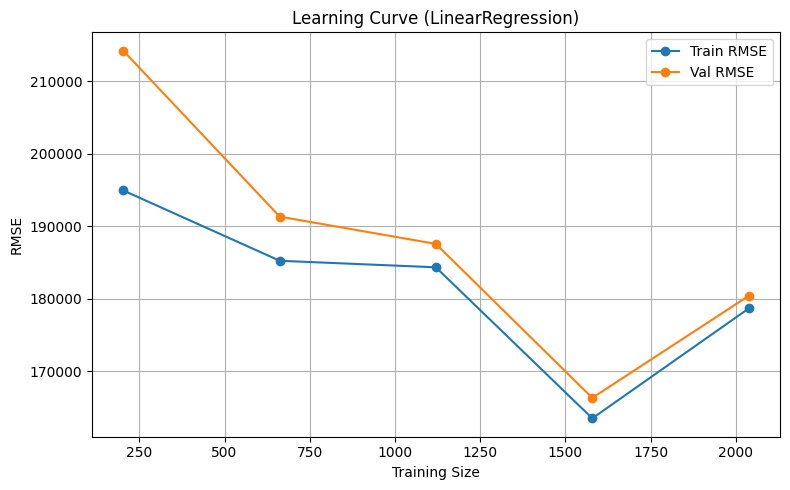

Mean CV score: 0.9458


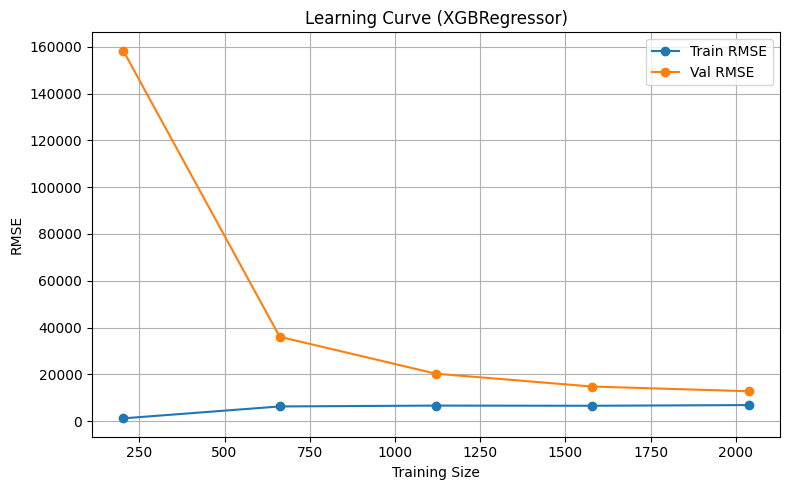

Mean CV score: 0.9960


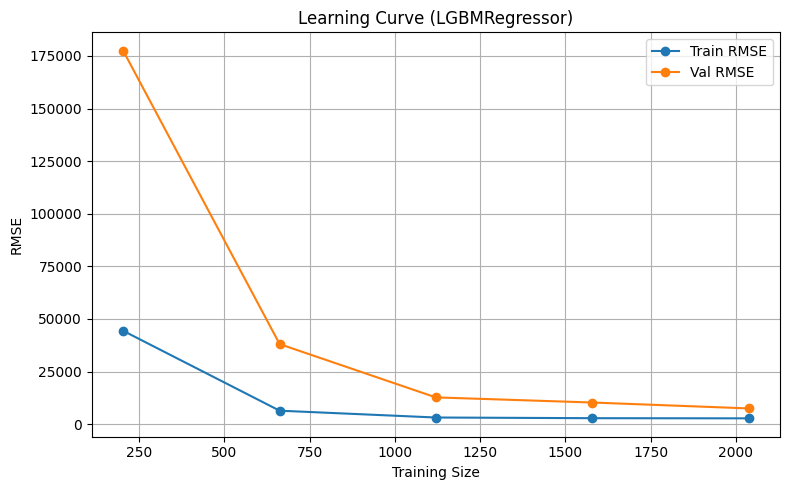

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 2038, number of used features: 6
[LightGBM] [Info] Start training from score 13549.168938
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 2038, number of used features: 6
[LightGBM] [Info] Start training from score 13579.341443
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 2038, number of used features: 6
[LightGBM] [Info] Start t

c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 6
[LightGBM] [Info] Start training from score 13628.070763
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 6
[LightGBM] [Info] Start training from score 13562.352761
Mean CV score: 0.9978


c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [37]:
for name, model in models.items():
    rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    train_sizes, train_scores, val_scores = learning_curve(
        model, x_train, y_train,
        cv=5, scoring=rmse_scorer,
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1,
        shuffle=True, random_state=42
    )
    train_rmse = -np.mean(train_scores, axis=1)
    val_rmse   = -np.mean(val_scores, axis=1)
    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_rmse, 'o-', label='Train RMSE')
    plt.plot(train_sizes, val_rmse,   'o-', label='Val RMSE')
    plt.title(f"Learning Curve ({name})")
    plt.xlabel("Training Size")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    cv_score = cross_val_score(model, x_train, y_train, cv=5).mean()
    print(f"Mean CV score: {cv_score:.4f}")

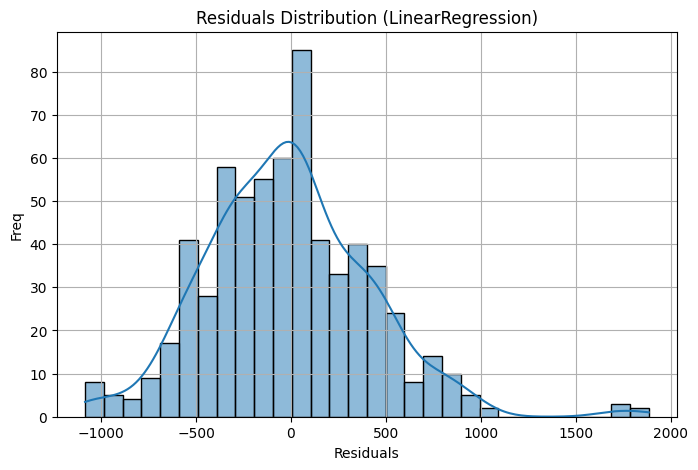

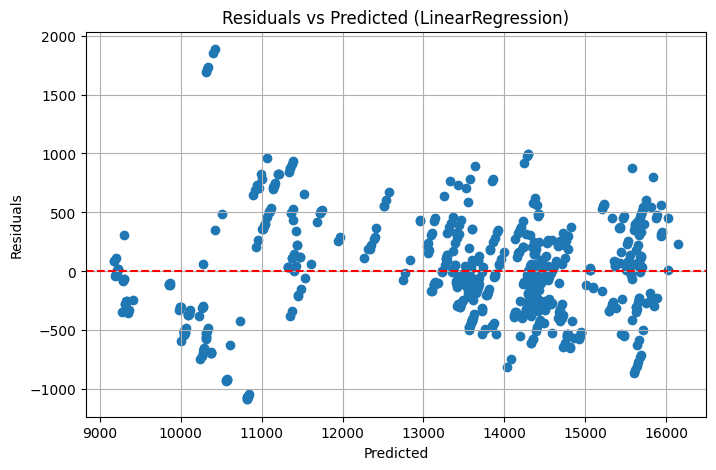

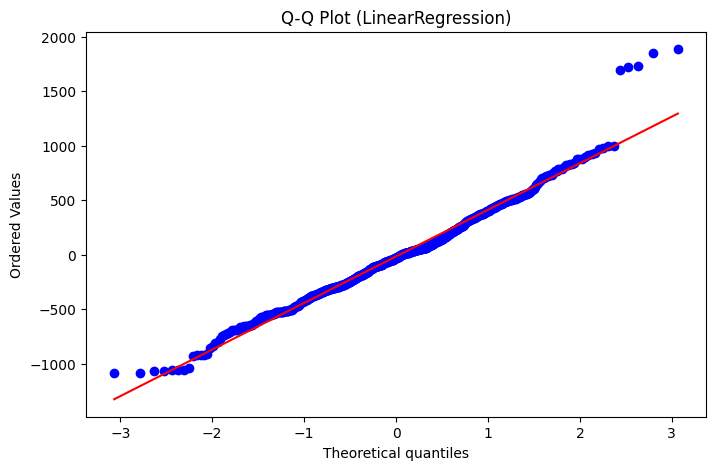

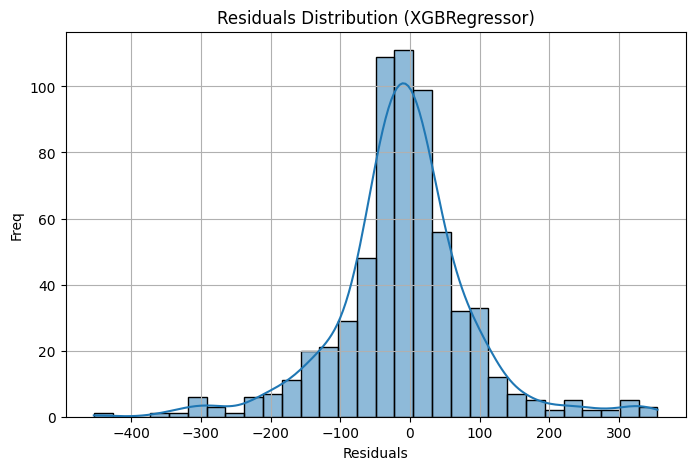

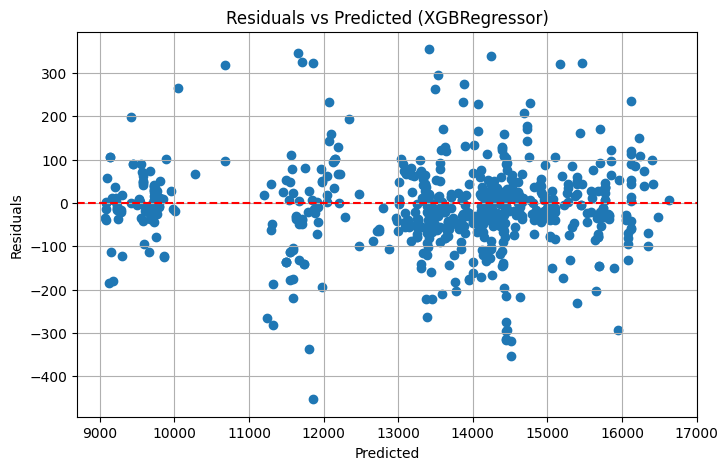

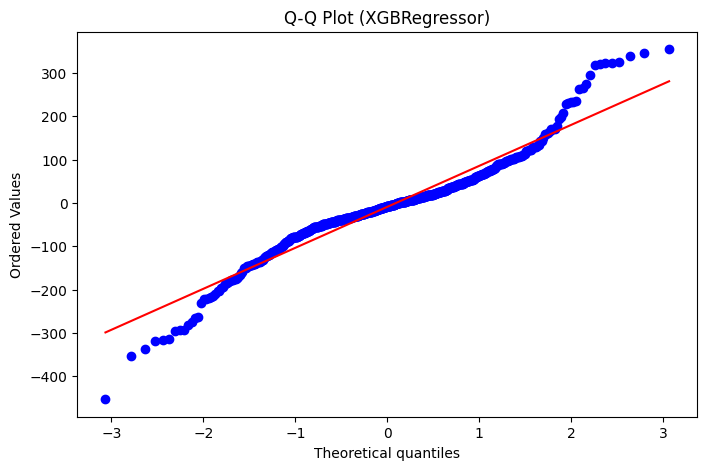

c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


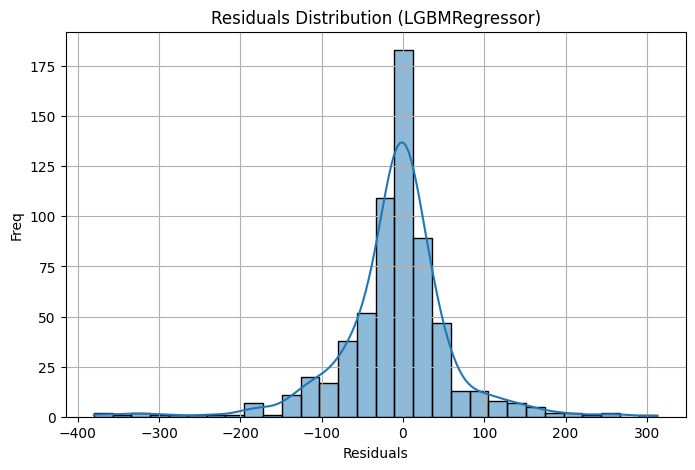

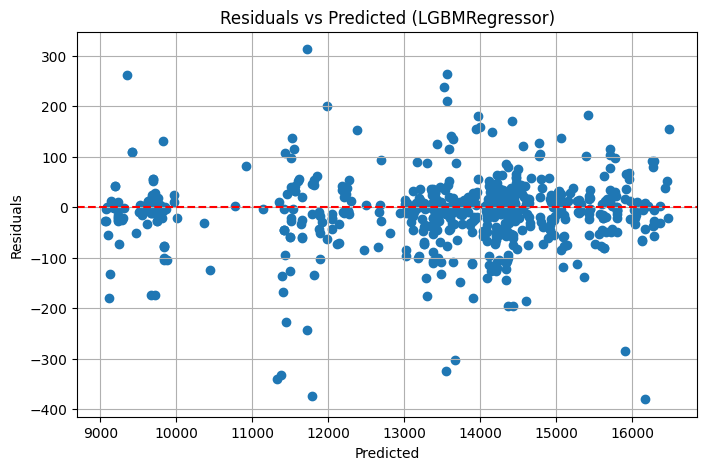

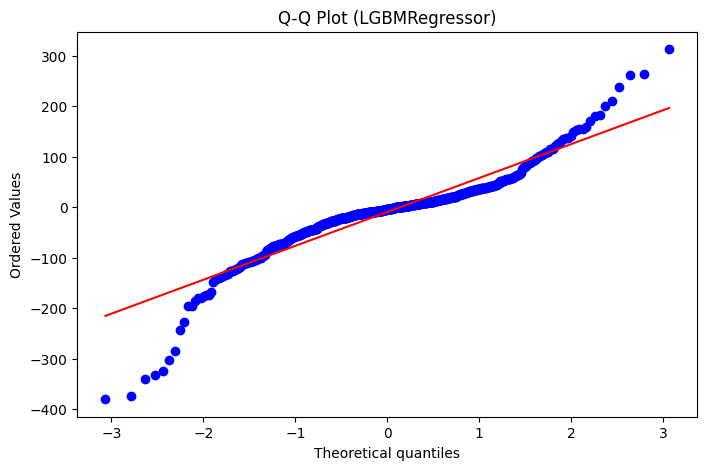

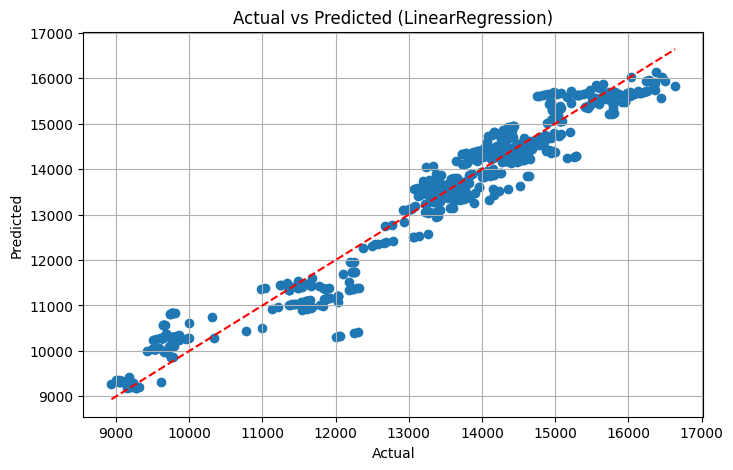

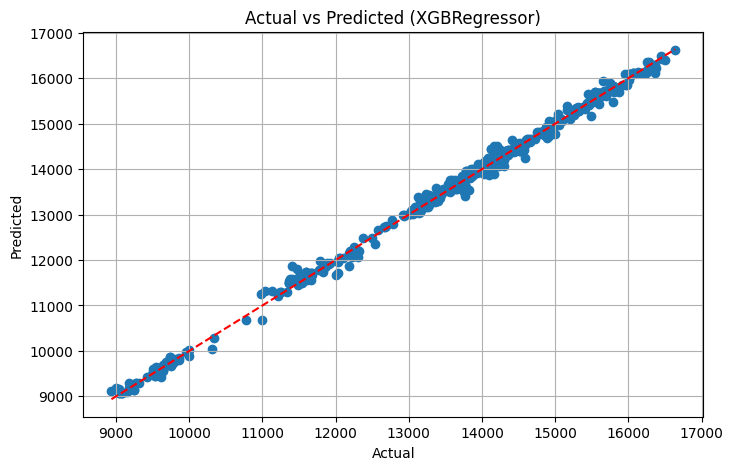

c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


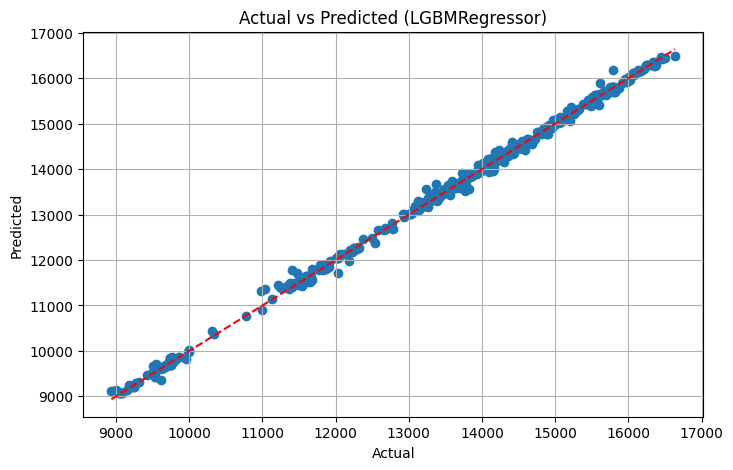

In [38]:
for name, model in models.items():
    y_pred = model.predict(x_test)
    residuals = y_test - y_pred
    plt.figure(figsize=(8,5))
    sns.histplot(residuals, kde=True, bins=30)
    plt.title(f"Residuals Distribution ({name})")
    plt.xlabel("Residuals")
    plt.ylabel("Freq")
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(8,5))
    plt.scatter(y_pred, residuals)
    plt.axhline(0, linestyle='--', color='r')
    plt.title(f"Residuals vs Predicted ({name})")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(8,5))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot ({name})")
    plt.show()

for name, model in models.items():
    y_pred = model.predict(x_test)
    plt.figure(figsize=(8,5))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
    plt.title(f"Actual vs Predicted ({name})")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(True)
    plt.show()